# Linear regression with Bayesian method
> * refrerence : 베이지안 계량경제학, 강규호 (2017) 

> * 기존의 다양한 이론이나 domanin knowledge를 바탕으로 사전적 정보를 바탕으로 종속변수(Y)는 외생적으로 주어진 설명변수(X)와 확률적 충격에 대한 선형함수형태로 결정된다는 연구자의 믿음을 포함 
> * $Y$ = $X_{1}$$\beta_{1}$ + $X_{2}$$\beta_{2}$+...+$X_{k}$$\beta_{k}$+$e$
> * $Y|X$, $\beta$, ${\sigma}^{2}$ ~ Normal($X\beta$, ${\sigma}^{2}$$I_{T}$)
> * 일반적으로 $\sigma^2$에 대한 사전분포는 $(\alpha_{0}/2, \delta_{0}/2)$를 파라미터를 가지는 역감마 분포
>> * 역감마 분포로부터 추출된 $\sigma^2$ 이 주어지면, $\beta$에 대한 사전분포는 $\beta_{0}$가 평균이고, $\sigma^{2}B_{0}$가 분산인 정규분포를 따른다고 가정
>> * $\sigma^{2}B_{0}$가 분산인 이유 두가지
1) $\beta$의 사후분포 도출이 용이
2) 오차항의 크기인 $\sigma^{2}$이 클수록 연구자가 같는 $\beta$에 대한 믿음의 강도가 약해질 수 있기 때문
>> * 하이퍼파라미터(hyper-parameter): $(\alpha_{0}, \delta_{0}, \beta_{0}, B_{0})$
>> * 사전적으로 $Y$와 $(\beta, \sigma^{2})$은 서로 상관관계 있는 확률변수

In [40]:
# reference : https://galeascience.wordpress.com/2016/09/11/bayesian-linear-regression-on-the-swiss-dataset/
library(ggplot2)
library(GGally)
library(dplyr)
library(BAS)
library(MASS)

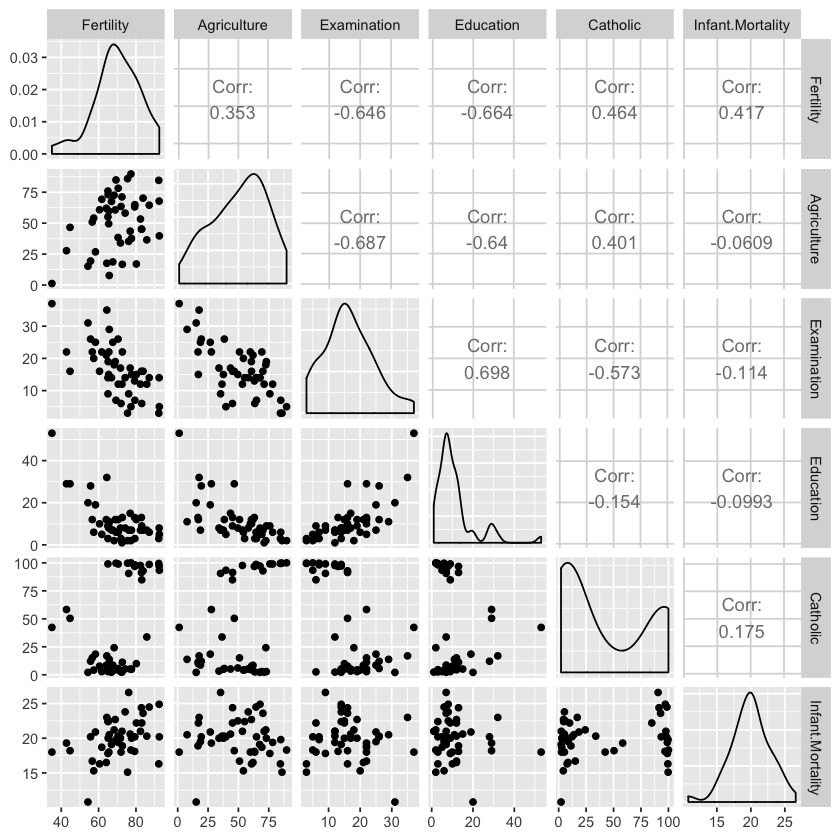

In [20]:
data(swiss)
ggpairs(swiss)

# Frequentist approach: Ordinary Least Squares(OLS)

In [23]:
swiss.lm_full <- lm(Fertility ~., data = swiss)
summary(swiss.lm_full)


Call:
lm(formula = Fertility ~ ., data = swiss)

Residuals:
     Min       1Q   Median       3Q      Max 
-15.2743  -5.2617   0.5032   4.1198  15.3213 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      66.91518   10.70604   6.250 1.91e-07 ***
Agriculture      -0.17211    0.07030  -2.448  0.01873 *  
Examination      -0.25801    0.25388  -1.016  0.31546    
Education        -0.87094    0.18303  -4.758 2.43e-05 ***
Catholic          0.10412    0.03526   2.953  0.00519 ** 
Infant.Mortality  1.07705    0.38172   2.822  0.00734 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 7.165 on 41 degrees of freedom
Multiple R-squared:  0.7067,	Adjusted R-squared:  0.671 
F-statistic: 19.76 on 5 and 41 DF,  p-value: 5.594e-10


In [28]:
predict <- data.frame(predict(swiss.lm_full))
predict$x <- swiss$Agriculture
names(predict) <- c('y', 'x')

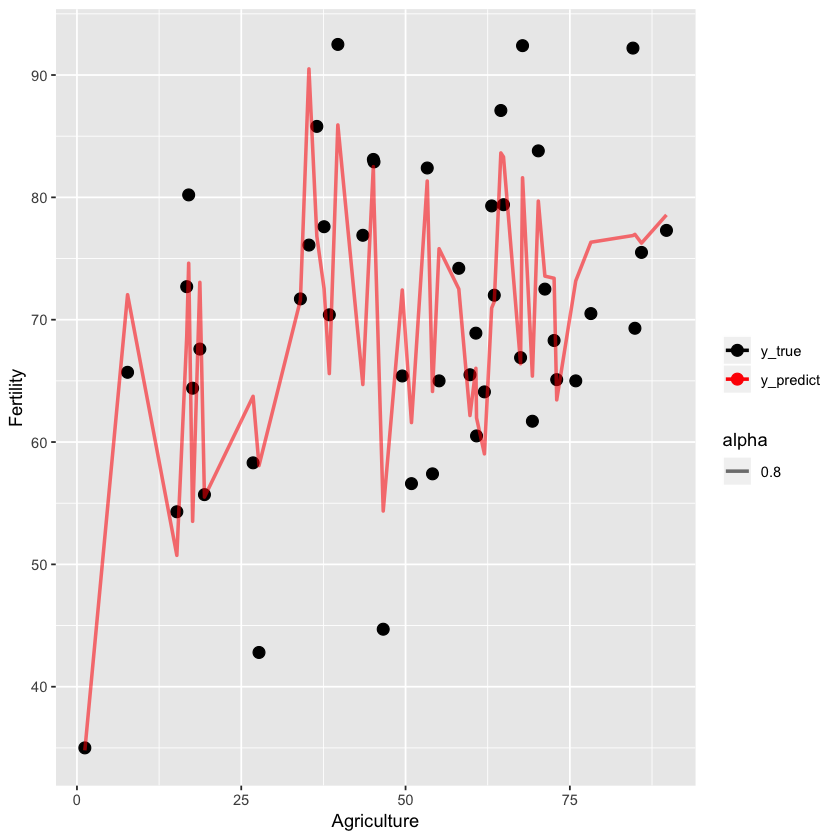

In [29]:
p <- ggplot() + geom_point(data=swiss, aes(Agriculture, Fertility,
                                          color = 'black'), size=3)
p <- p + geom_line(data=predict, aes(x=x, y=y, color='red', alpha = 0.8), size=1)
p + scale_colour_manual(name="", values=c('black', 'red'), labels=c('y_true', 'y_predict'))

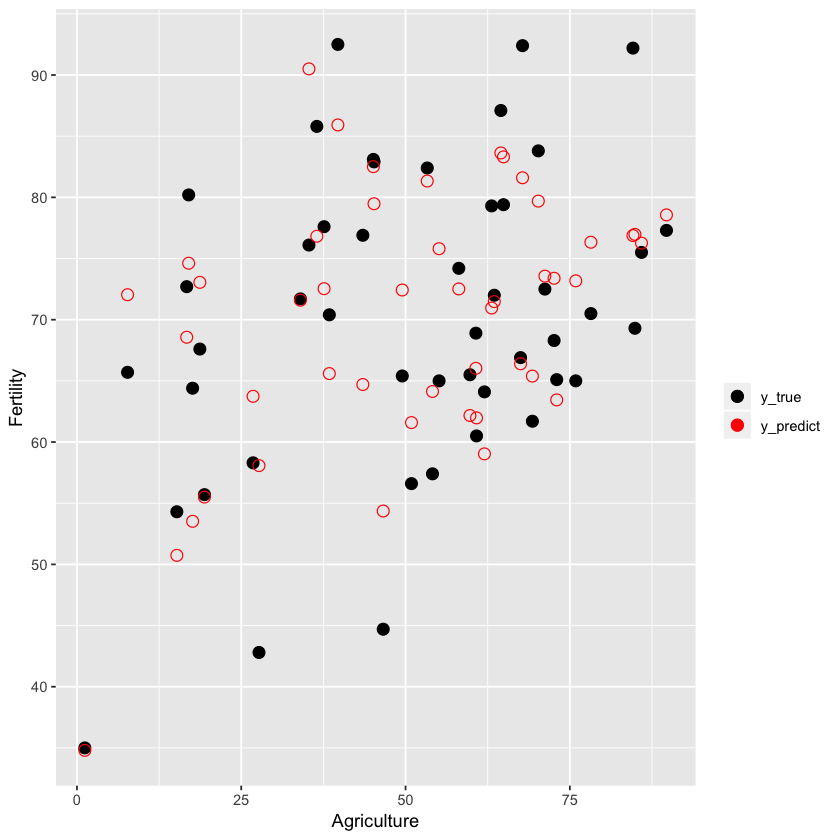

In [31]:
p <- ggplot() + geom_point(data = swiss, aes(Agriculture, Fertility, color='black'), size=3)
p <- p + geom_point(data = predict, aes(x=x, y=y, color ='red'), size=3, shape=1)
p + scale_colour_manual(name='', values=c('black', 'red'), labels=c('y_true', 'y_predict'))

In [32]:
stepAIC(lm(Fertility ~., data=swiss), k=log(nrow(rock)))

Start:  AIC=201.92
Fertility ~ Agriculture + Examination + Education + Catholic + 
    Infant.Mortality

                   Df Sum of Sq    RSS    AIC
- Examination       1     53.03 2158.1 199.22
<none>                          2105.0 201.92
- Agriculture       1    307.72 2412.8 204.46
- Infant.Mortality  1    408.75 2513.8 206.39
- Catholic          1    447.71 2552.8 207.11
- Education         1   1162.56 3267.6 218.71

Step:  AIC=199.22
Fertility ~ Agriculture + Education + Catholic + Infant.Mortality

                   Df Sum of Sq    RSS    AIC
<none>                          2158.1 199.22
- Agriculture       1    264.18 2422.2 200.77
- Infant.Mortality  1    409.81 2567.9 203.52
- Catholic          1    956.57 3114.6 212.59
- Education         1   2249.97 4408.0 228.91



Call:
lm(formula = Fertility ~ Agriculture + Education + Catholic + 
    Infant.Mortality, data = swiss)

Coefficients:
     (Intercept)       Agriculture         Education          Catholic  
         62.1013           -0.1546           -0.9803            0.1247  
Infant.Mortality  
          1.0784  


# Bayesian linear regression

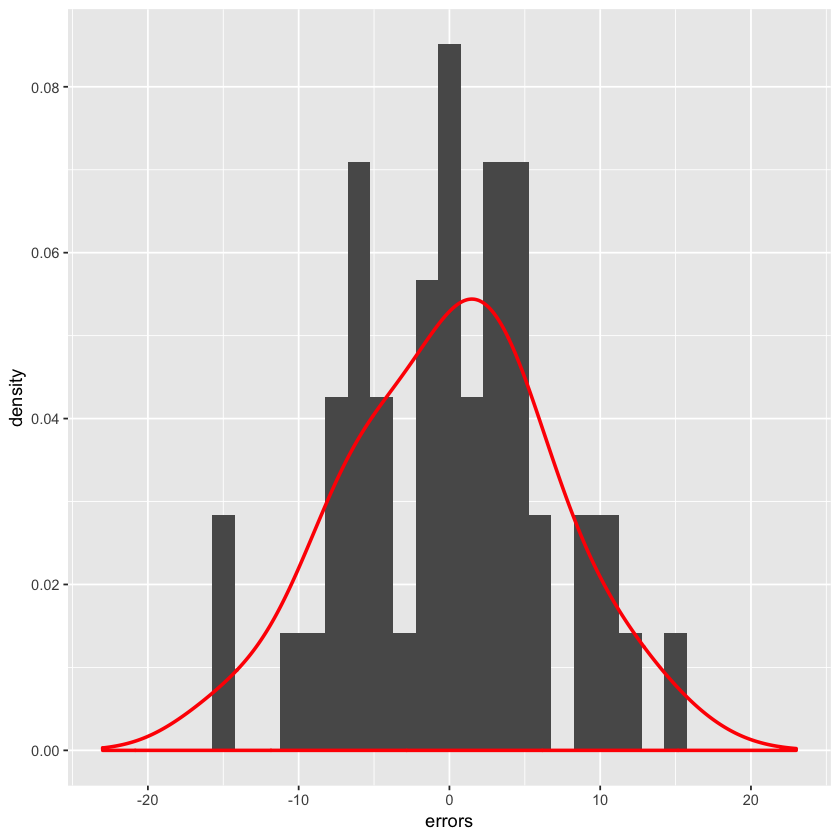

In [33]:
# Compute errors
errors = resid(swiss.lm_full)
# Plot histogram and fitted line
as.data.frame(errors) %>% ggplot(aes(errors)) +
    geom_histogram(binwidth=1.5, aes(y=..density..)) +
    geom_density(adjust=1.2, size=1, color='red') +
    xlim(-23, 23)

In [34]:
swiss.lm_bay = bas.lm(Fertility ~ ., data = swiss,
                      prior = 'BIC', modelprior = uniform())
swiss.lm_bay


Call:
bas.lm(formula = Fertility ~ ., data = swiss, prior = "BIC", 
    modelprior = uniform())


 Marginal Posterior Inclusion Probabilities: 
       Intercept       Agriculture       Examination         Education  
          1.0000            0.7111            0.2062            0.9987  
        Catholic  Infant.Mortality  
          0.9709            0.9203  

In [35]:
swiss.lm_bay$priorprobs

[1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [36]:
swiss.lm_bay$postprobs

[1] 5.975898e-10 2.576101e-08 1.381908e-02 3.623654e-02 6.154698e-04
 [6] 9.984254e-08 7.398810e-05 1.991853e-09 1.954690e-04 4.985251e-01
[11] 3.752047e-04 7.680347e-09 1.981669e-06 7.726561e-06 1.542760e-04
[16] 1.755913e-07 2.909603e-05 2.818531e-05 7.009237e-06 1.555411e-05
[21] 1.605360e-07 2.265415e-01 1.640323e-04 5.744487e-02 1.315500e-02
[26] 1.039831e-08 9.627788e-03 3.932309e-03 6.688618e-03 8.866852e-04
[31] 1.304797e-01 9.942863e-04

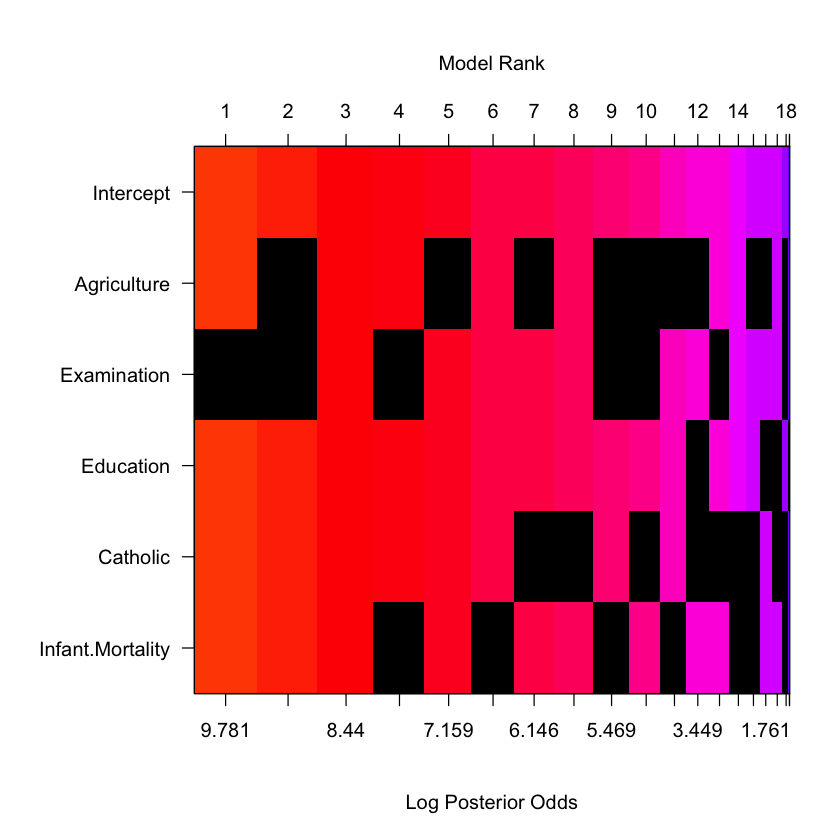

In [37]:
image(swiss.lm_bay, rotate=FALSE)

In [43]:
summary(swiss.lm_bay)

,P(B != 0 | Y),model 1,model 2,model 3,model 4,model 5
Intercept,1.0000000,1.0000,1.0000000,1.0000000,1.0000000,1.00000000
Agriculture,0.7110962,1.0000,0.0000000,1.0000000,1.0000000,0.00000000
Examination,0.2061621,0.0000,0.0000000,1.0000000,0.0000000,1.00000000
Education,0.9987205,1.0000,1.0000000,1.0000000,1.0000000,1.00000000
Catholic,0.9709322,1.0000,1.0000000,1.0000000,1.0000000,1.00000000
Infant.Mortality,0.9203480,1.0000,1.0000000,1.0000000,0.0000000,1.00000000
BF,NA,1.0000,0.4544234,0.2617315,0.1152296,0.07268748
PostProbs,NA,0.4985,0.2265000,0.1305000,0.0574000,0.03620000
R2,NA,0.6993,0.6625000,0.7067000,0.6423000,0.66390000
dim,NA,5.0000,4.0000000,6.0000000,4.0000000,5.00000000


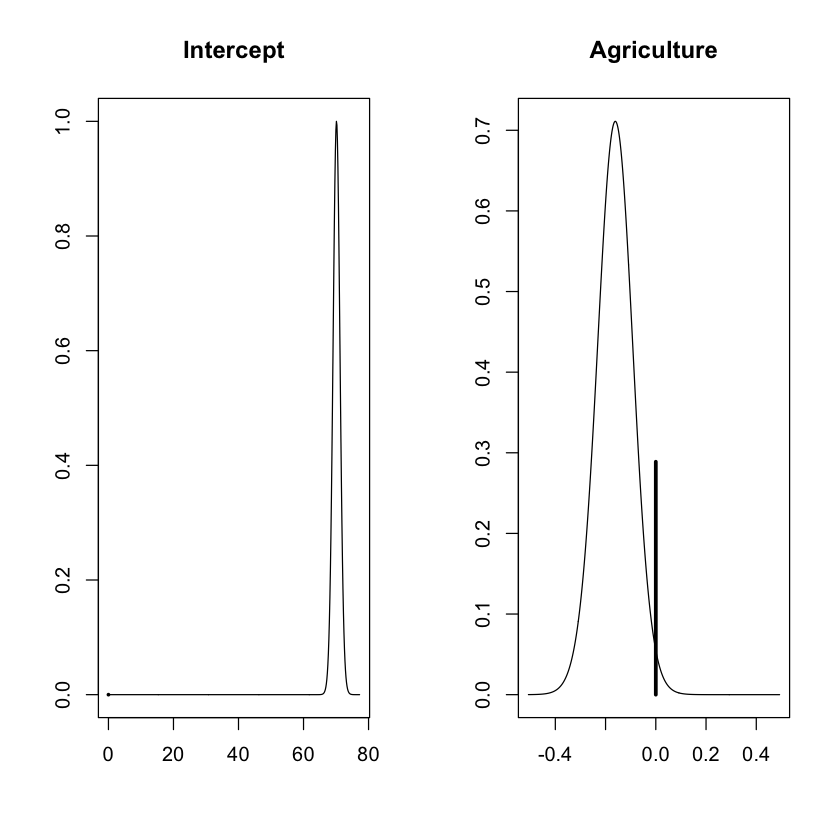

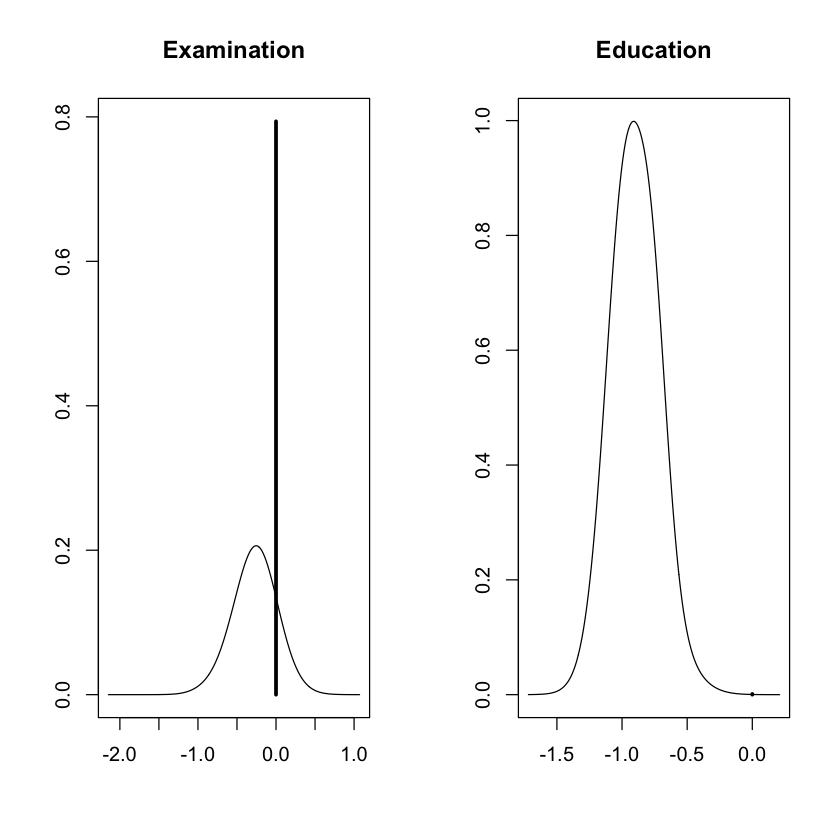

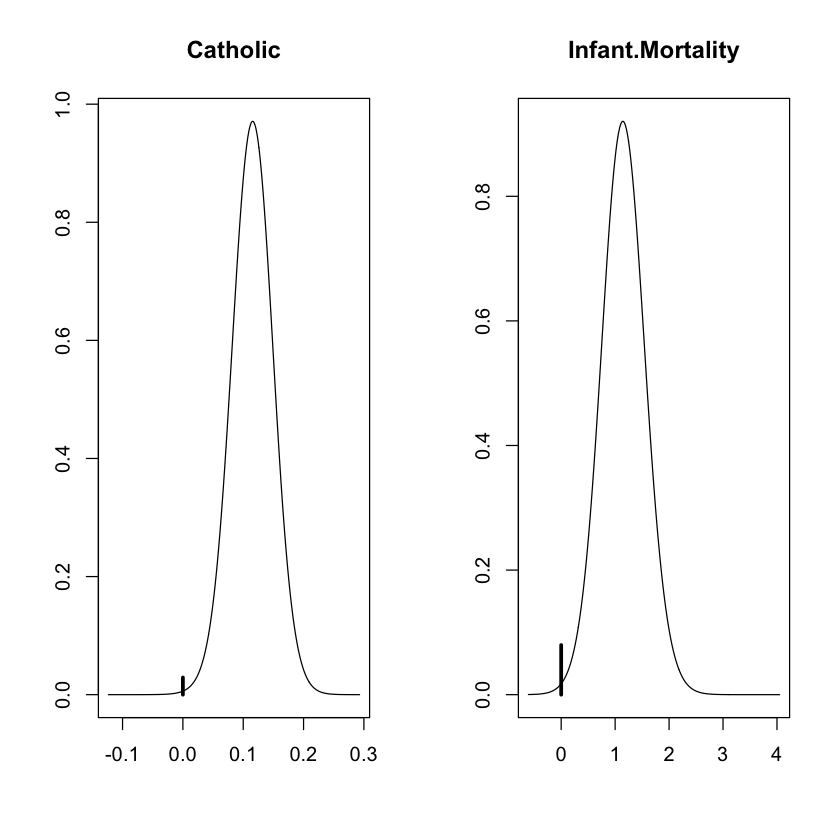

In [45]:
par(mfrow=c(1,2))
plot(coefficients(swiss.lm_bay))
# Notice how our weakest feature, “Examination”, has a large overlap with 0. In each plot the overlap is quantified by the height of the black vertical line extending up from x=0.

In [46]:
set.seed(1)
n = nrow(swiss)
train = sample(1:n, size = round(0.6*n), replace=FALSE)
swiss.train = swiss[train,]
swiss.test = swiss[-train,]

In [47]:
swiss.lm_bay = bas.lm(Fertility ~ ., data = swiss.train,
                      prior = 'BIC', modelprior = uniform())

In [49]:
# Set up matrix to store results in
results = matrix(NA, ncol=4, nrow=1)
colnames(results) = c('BMA', 'BPM', 'MPM', 'HPM')
 
# Make predictions for each aggregated model
for (name in colnames(results)) {
    y_pred = predict(swiss.lm_bay, swiss.test, estimator=name)$fit
    results[1, name] = cv.summary.bas(y_pred, swiss.test$Fertility)
}
 
# Print results
options(digits = 4)
results


# BMA: Bayesian Model Averaging (mean of best models)
# BPM: Bayesian Posterior Model (best predictave model according to some loss function e.g., squared error)
# MPM: Median Probability Model (including all predictors whose marginal probabilities of being non zero are above 50%)
# HPM: Highest Probability Model

BMA,BPM,MPM,HPM
8.934,9.036,9.036,9.036


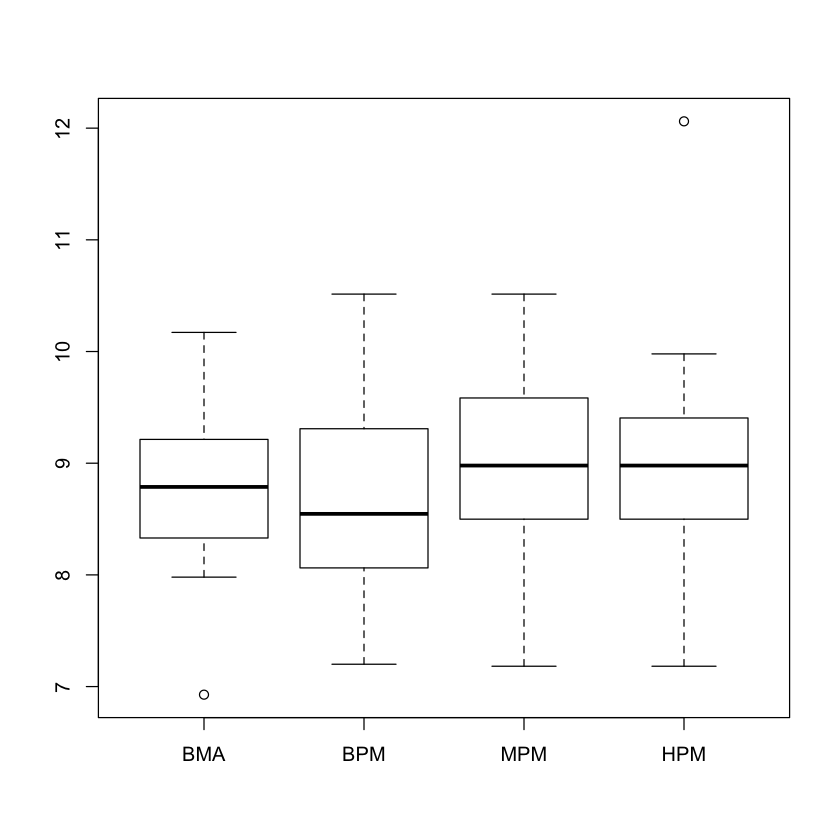

In [50]:
set.seed(99)
results = matrix(NA, ncol=4, nrow=10)
colnames(results) = c('BMA', 'BPM', 'MPM', 'HPM')
 
for (i in 1:10) {
    n = nrow(swiss)
    train = sample(1:n, size = round(0.6*n), replace=FALSE)
    swiss.train = swiss[train,]
    swiss.test = swiss[-train,]
    swiss.lm_bay = bas.lm(Fertility ~ ., data = swiss.train,
                          prior = 'BIC', modelprior = uniform())
 
    for (name in colnames(results)) {
        y_pred = predict(swiss.lm_bay, swiss.test, estimator=name)$fit
        results[i, name] = cv.summary.bas(y_pred, swiss.test$Fertility)
    }
}
 
boxplot(results)

In [51]:
swiss.lm_bay <- bas.lm(Fertility ~ ., data = swiss.train,
                      prior = 'g-prior',
                      modelprior = beta.binomial(1,1))

# What happens when you run K-fold cross validation with the substitution below?

In [53]:
swiss.lm_bay


Call:
bas.lm(formula = Fertility ~ ., data = swiss.train, prior = "g-prior", 
    modelprior = beta.binomial(1, 1))


 Marginal Posterior Inclusion Probabilities: 
       Intercept       Agriculture       Examination         Education  
           1.000             0.349             0.420             0.896  
        Catholic  Infant.Mortality  
           0.844             0.744  